# Selection of neutrons using Flow-files

This notebook produces differente figures using truth information
contained in flow files

In [1]:
import numpy as np 
import pandas as pd 
import h5py
import uproot
import glob 
import matplotlib.pyplot as plt
from utils import ParticleCode

# Load your custom style 
plt.style.use('./cfg/my_custom_plot.mplstyle')

# use these lines on top of your matplotlib script
import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=4):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator        
 
# Now use matplotlib as usual.       
import matplotlib.pyplot as plt
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True


In [2]:
# Geometry for MiniRun 5
anode_xs = np.array([-63.931, -3.069, 3.069, 63.931])
anode_ys = np.array([-19.8543, 103.8543])  # two ys
anode_zs = np.array([-64.3163, -2.6837, 2.6837, 64.3163])  # four zs

# hit coordinates are in cm
detector_center = (0, 0, 0)
anode_ys = anode_ys - 42

In [3]:
plot_dir = "./plots/"

# Get PDG codes
neutron_pdg = ParticleCode().neutron
proton_pdg = ParticleCode().proton
numu_pdg = ParticleCode().numu
nue_pdg = ParticleCode().nue
neutron_mass = ParticleCode().neutron_mass


# TO DO: Use hadron subprocess label! 
# G4 Subprocess labels
HadronElastic = 111
HadronInelastic = 121
HadronCapture = 131
HadronChargeExchange = 161
NeutronKiller=403
EMScintillation = 22 
GeneralStepLimit=401
Hadronic = 4
Decay = 6 

In [170]:
nu_x = []
nu_y = []
nu_z = []
numu_CC = []
numu_NC = []
nue_CC = []
nue_NC = []
Ar_id = [] 
neutron_energy = [] 
n_neutrons = []
n_end_neutrons = [] 
neutrons_traj_id = []
neutron_start_x = []
neutron_start_y = []
neutron_start_z = []
neutron_end_x = []
neutron_end_y = []
neutron_end_z = []
neutron_start_t = []  
neutron_end_t = []

n_hadronic_E = []
n_decay_E = []
n_elastic_E = []
n_inelastic_E = []
n_capture_E = []
n_ce_E = [] 
n_killer_E = []
n_general_E = []
neutron_counter = 0  
sample_for_evd = []
n_traj_E = []
n_process_type = [] 
n_em_E = [] 
n_fiducial_E = [] 
neutron_end_volume = [] 

file_counter=0

for filename in glob.glob(f_directory+'*.hdf5'):
    print(filename)
    f=h5py.File(filename,'r')

    # Nu interactions
    Interactions = f['mc_truth/interactions/data']

    # True Particle information 
    MCStack = f['mc_truth/stack/data']

    # True Particle Trajectories 
    Trajectories = f['mc_truth/trajectories/data']


    # Apply filter for interactions with Ar only 
    Ar_id_temp = Interactions[Interactions['target']==18]['vertex_id']

    # Retrieve neutrino info 
    nu_x_temp = Interactions[Interactions['target']==18]['vertex'][:,0]
    nu_y_temp = Interactions[Interactions['target']==18]['vertex'][:,1]
    nu_z_temp = Interactions[Interactions['target']==18]['vertex'][:,2]
    numu_CC_temp = Interactions[(Interactions['isCC']==1) & (Interactions['target']==18) & (np.abs(Interactions['nu_pdg'])==numu_pdg)]['Enu']/1000.
    numu_NC_temp = Interactions[(Interactions['isCC']==0) & (Interactions['target']==18) & (np.abs(Interactions['nu_pdg'])==numu_pdg)]['Enu']/1000.
    nue_CC_temp = Interactions[(Interactions['isCC']==1) & (Interactions['target']==18) & (np.abs(Interactions['nu_pdg'])==nue_pdg)]['Enu']/1000.
    nue_NC_temp = Interactions[(Interactions['isCC']==0) & (Interactions['target']==18) & (np.abs(Interactions['nu_pdg'])==nue_pdg)]['Enu']/1000.

    # Get only nu-Ar interactions 
    mask_inter = np.isin(Interactions['vertex_id'],Ar_id_temp)
    mask_stack = np.isin(MCStack['vertex_id'], Ar_id_temp)
    mask_traj = np.isin(Trajectories['vertex_id'], Ar_id_temp)

    Interactions_ar = Interactions[mask_inter]
    MCStack_ar = MCStack[mask_stack]
    Trajectories_ar = Trajectories[mask_traj]



    # Final state - neutron 
    neutron_energy_temp = MCStack_ar[(MCStack_ar['part_status'] == 1) & (MCStack_ar['part_pdg']==neutron_pdg)]['part_4mom'][:,3]
    neutron_traj_id_temp = MCStack_ar[(MCStack_ar['part_status']== 1) & (MCStack_ar['part_pdg']==neutron_pdg)]['traj_id']
    neutron_start_t_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & (Trajectories_ar['primary']==True)]['t_start']
    neutron_end_t_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & (Trajectories_ar['primary']==True)]['t_end']
    neutron_start_x_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) &(Trajectories_ar['primary']==True)]['xyz_start'][:,0]
    neutron_start_y_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) &(Trajectories_ar['primary']==True)]['xyz_start'][:,1]
    neutron_start_z_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) &(Trajectories_ar['primary']==True)]['xyz_start'][:,2]
    neutron_end_x_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) &(Trajectories_ar['primary']==True)]['xyz_end'][:,0]
    neutron_end_y_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) &(Trajectories_ar['primary']==True)]['xyz_end'][:,1]
    neutron_end_z_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) &(Trajectories_ar['primary']==True)]['xyz_end'][:,2]

    neutron_end_volume.extend(Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) &(Trajectories_ar['primary']==True)]['xyz_end'])
    
    n_all_traj_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True)]['end_subprocess']
    

    n_em_E_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True)  &(Trajectories_ar['end_subprocess']==EMScintillation) ]['E_start']
    
    n_elastic_E_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True)  &(Trajectories_ar['end_subprocess']==HadronElastic) ]['E_start']
    
    n_inelastic_E_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True) & (Trajectories_ar['end_subprocess']==HadronInelastic)]['E_start']

    n_capture_E_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True) & (Trajectories_ar['end_subprocess']==HadronCapture)]['E_start']
    
    n_ce_E_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True) & (Trajectories_ar['end_subprocess']==HadronChargeExchange)]['E_start']

    n_killer_E_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True) & (Trajectories_ar['end_subprocess']==NeutronKiller)]['E_start']
    
    n_general_E_temp = Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True) & (Trajectories_ar['end_subprocess']==GeneralStepLimit)]['E_start']


    neutron_start_t.extend(neutron_start_t_temp)
    neutron_end_t.extend(neutron_end_t_temp)
    neutron_start_x.extend(neutron_start_x_temp)
    neutron_start_y.extend(neutron_start_y_temp)
    neutron_start_z.extend(neutron_start_z_temp)
    neutron_end_x.extend(neutron_end_x_temp)
    neutron_end_y.extend(neutron_end_y_temp)
    neutron_end_z.extend(neutron_end_z_temp)
    neutrons_traj_id.extend(neutron_traj_id_temp)
    n_elastic_E.extend(n_elastic_E_temp)
    n_inelastic_E.extend(n_inelastic_E_temp)
    n_capture_E.extend(n_capture_E_temp)
    n_ce_E.extend(n_ce_E_temp)
    n_killer_E.extend(n_killer_E_temp)
    n_general_E.extend(n_general_E_temp)
    n_traj_E.extend(n_all_traj_temp)
    n_em_E.extend(n_em_E_temp)
    
    
    n_process_type.extend(Trajectories_ar[(Trajectories_ar['pdg_id']==neutron_pdg) & 
                                    (Trajectories_ar['primary']==True)]['end_process'])
    
    n_end_neutrons.append(len(n_inelastic_E_temp) + len(n_capture_E_temp) + len(n_killer_E_temp) + len(n_em_E_temp))

    nneutron_temp = len(neutron_energy_temp)
    nneutron_back = len(neutron_start_t_temp)
    # Iterate over nu-Ar interactions 
    if(nneutron_temp>0):
        neutron_counter+=1

    n_neutrons.append(nneutron_temp)
    nu_x.extend(nu_x_temp)
    nu_y.extend(nu_y_temp)
    nu_z.extend(nu_z_temp)
    numu_CC.extend(numu_CC_temp)
    numu_NC.extend(numu_NC_temp)
    nue_CC.extend(nue_CC_temp)
    nue_NC.extend(nue_NC_temp)
    Ar_id.extend(Ar_id_temp)
    neutron_energy.extend(neutron_energy_temp)
    file_counter+=1
    if file_counter==100: break



/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000234.FLOW.hdf5
/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000584.FLOW.hdf5
/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000076.FLOW.hdf5
/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000147.FLOW.hdf5
/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000217.FLOW.hdf5
/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta1/FLOW/0000000/MiniRun5_1E19_RHC.flow.0000117.FLOW.hdf5
/global/cfs/cdirs/dune/www/data/2x2/simu

In [171]:
print("Priting Info here:...")
print("Number of nu-Ar interactions: ", len(Ar_id))
print("Number of nu-Ar interactions producing neutrons: ", neutron_counter)
print("Fraction of nu interactions with neutrons in the final-state: ",neutron_counter/len(Ar_id))




print("======================")
print("Sanity check: Number of neutrons")
print("Number of neutrons in MCStack: ", np.sum(n_neutrons))
print("Number of neutrons in Trajectories: ", np.sum(n_end_neutrons))
print("======================")


print(np.unique(n_traj_E))
print(np.unique(n_process_type))


Priting Info here:...
Number of nu-Ar interactions:  7152
Number of nu-Ar interactions producing neutrons:  100
Fraction of nu interactions with neutrons in the final-state:  0.013982102908277404
Sanity check: Number of neutrons
Number of neutrons in MCStack:  18003
Number of neutrons in Trajectories:  18003
[ 22 121 131 403]
[2 4 7]


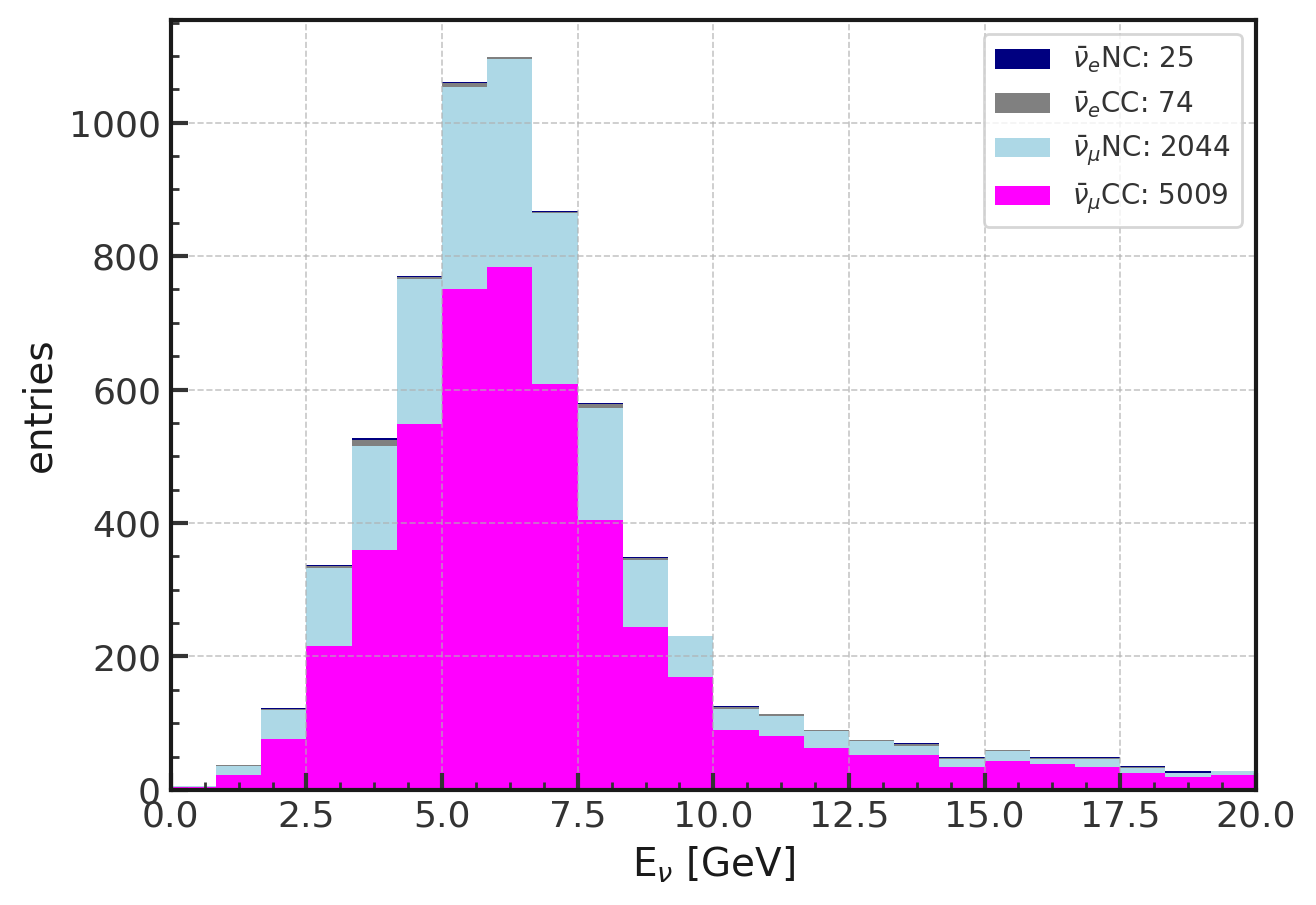

In [172]:
Enu_CCNC = [numu_CC, numu_NC, nue_CC, nue_NC]
label = ["$\\bar{\\nu}_{\\mu}$"+f"CC: {len(numu_CC)}", "$\\bar{\\nu}_{\\mu}$" + f"NC: {len(numu_NC)}",
         "$\\bar{\\nu}_{e}$"+f"CC: {len(nue_CC)}", "$\\bar{\\nu}_{e}$" + f"NC: {len(nue_NC)}"]
colors_stack = ['magenta','lightblue','gray','navy']
plt.hist(Enu_CCNC, histtype='stepfilled', stacked=True, label=label, bins=60, range=(0,50),color=colors_stack)
plt.xlabel("E$_{\\nu}$ [GeV]")
plt.ylabel("entries")
plt.xlim(0.,20.)
plt.legend()
plt.savefig(plot_dir + "nu_Ar_energy_dist.png",bbox_inches="tight")
plt.savefig(plot_dir + "nu_Ar_energy_dist.pdf",bbox_inches="tight")
plt.show()


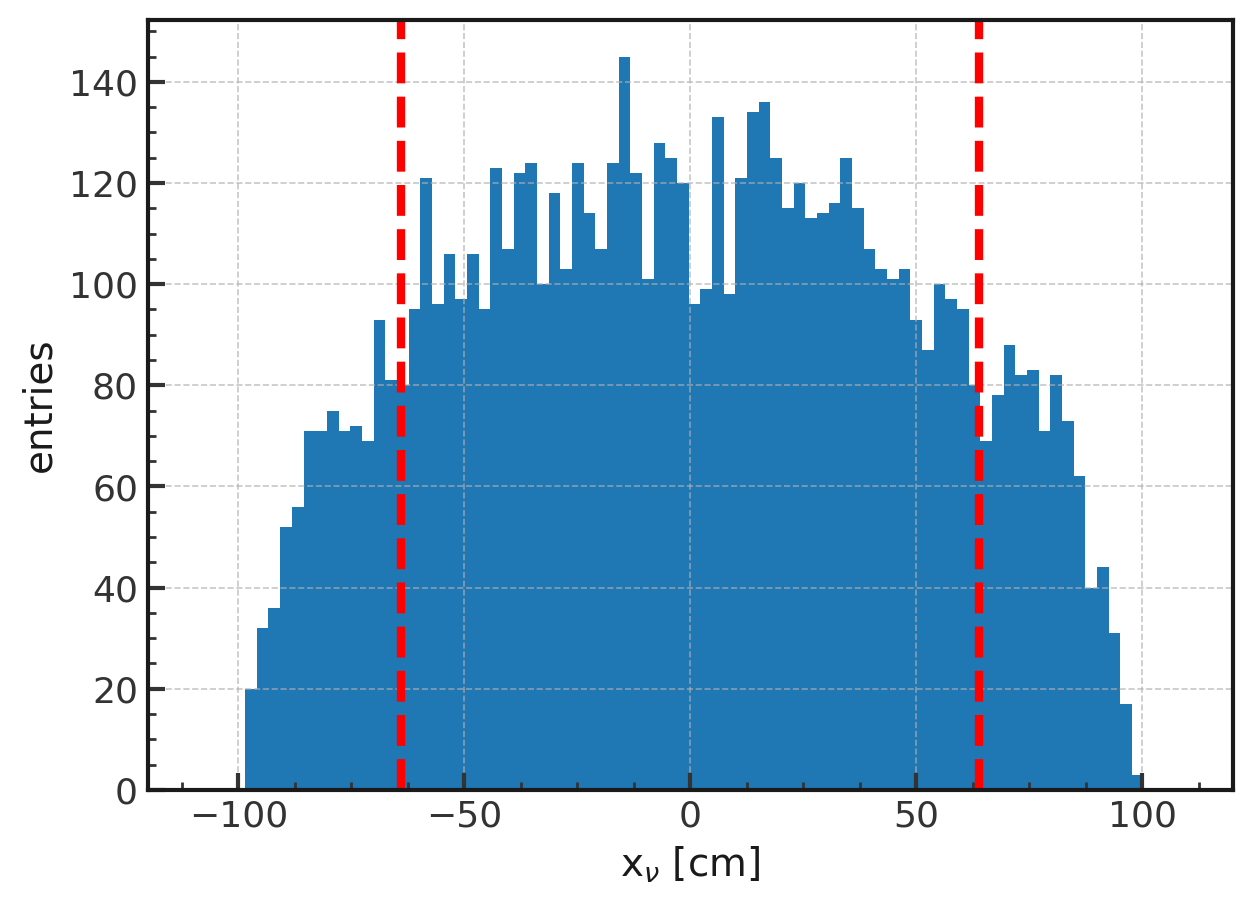

In [173]:
plt.hist(nu_x, histtype='stepfilled', stacked=True, bins=100)
plt.xlabel("x$_{\\nu}$ [cm]")
plt.ylabel("entries")
plt.axvline(anode_xs[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_xs[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-120,120)
plt.savefig(plot_dir + "nu_vertex_x.png",bbox_inches="tight")
plt.savefig(plot_dir + "nu_vertex_x.pdf",bbox_inches="tight")
plt.show()

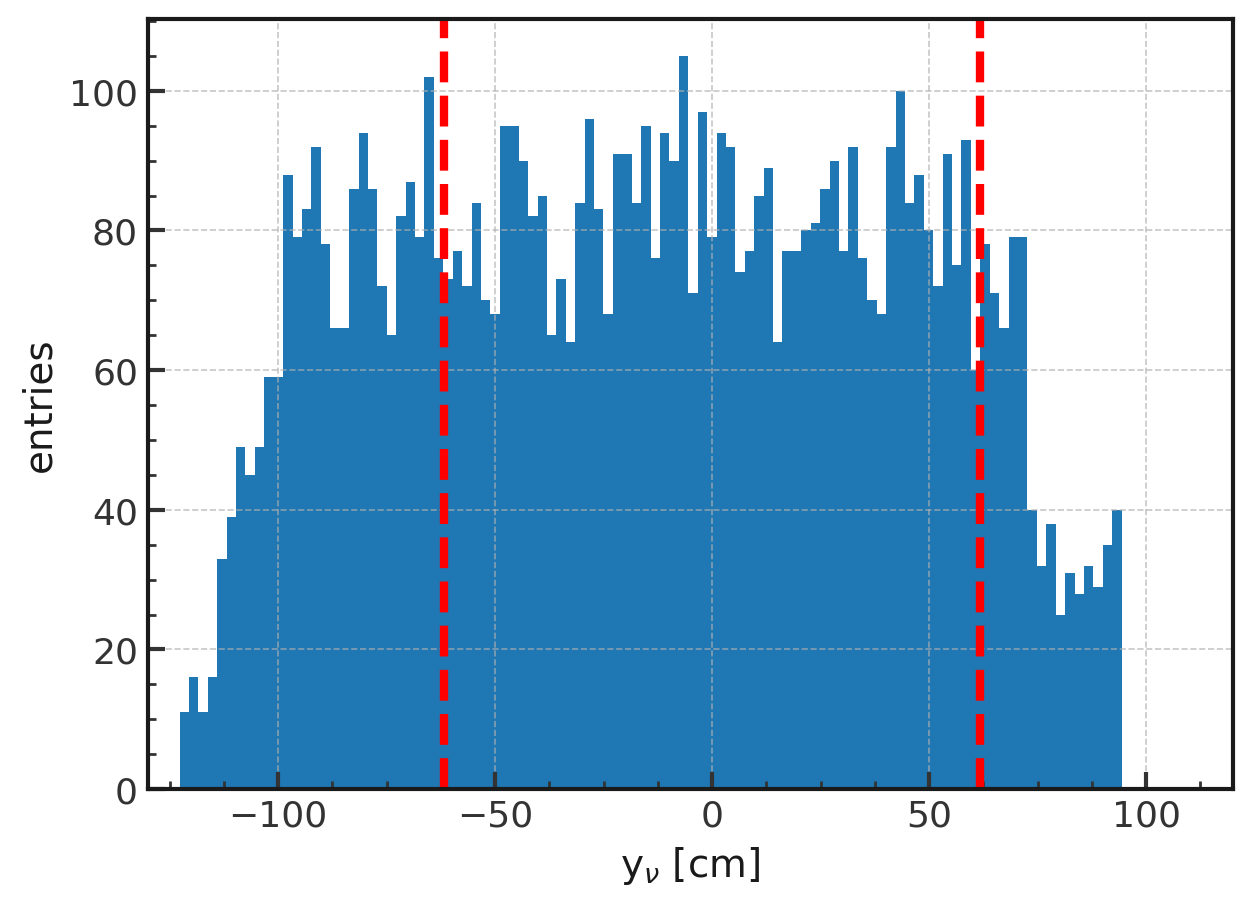

In [174]:
plt.hist(nu_y, histtype='stepfilled', bins=100)
plt.xlabel("y$_{\\nu}$ [cm]")
plt.ylabel("entries")
plt.axvline(anode_ys[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_ys[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-130,120)
plt.savefig(plot_dir + "nu_vertex_y.png",bbox_inches="tight")
plt.savefig(plot_dir + "nu_vertex__y.pdf",bbox_inches="tight")
plt.show()

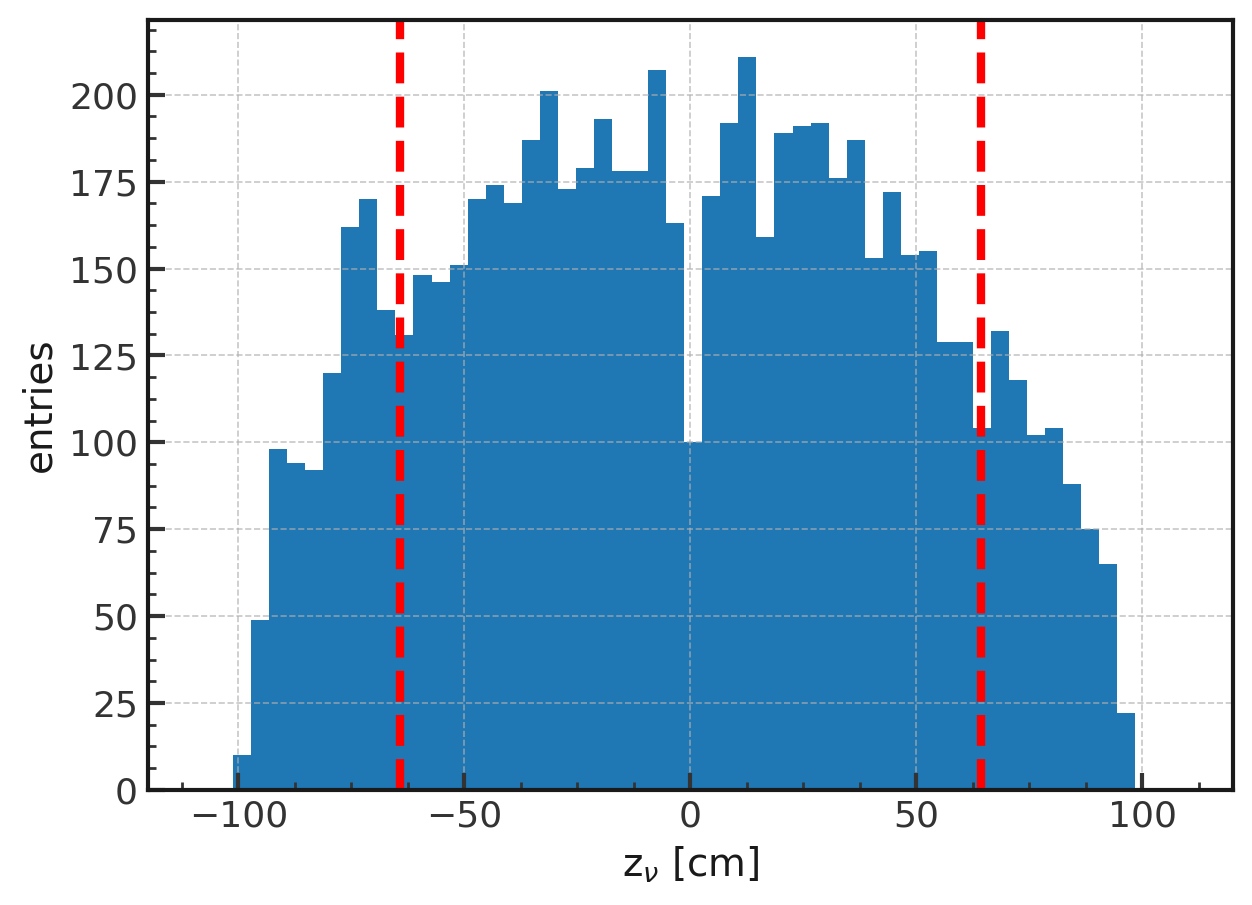

In [175]:
plt.hist(nu_z, histtype='stepfilled', bins=70)
plt.xlabel("z$_{\\nu}$ [cm]")
plt.ylabel("entries")
plt.axvline(anode_zs[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_zs[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-120,120)
plt.savefig(plot_dir + "nu_vertex_z.png",bbox_inches="tight")
plt.savefig(plot_dir + "nu_vertex_z.pdf",bbox_inches="tight")
plt.show()

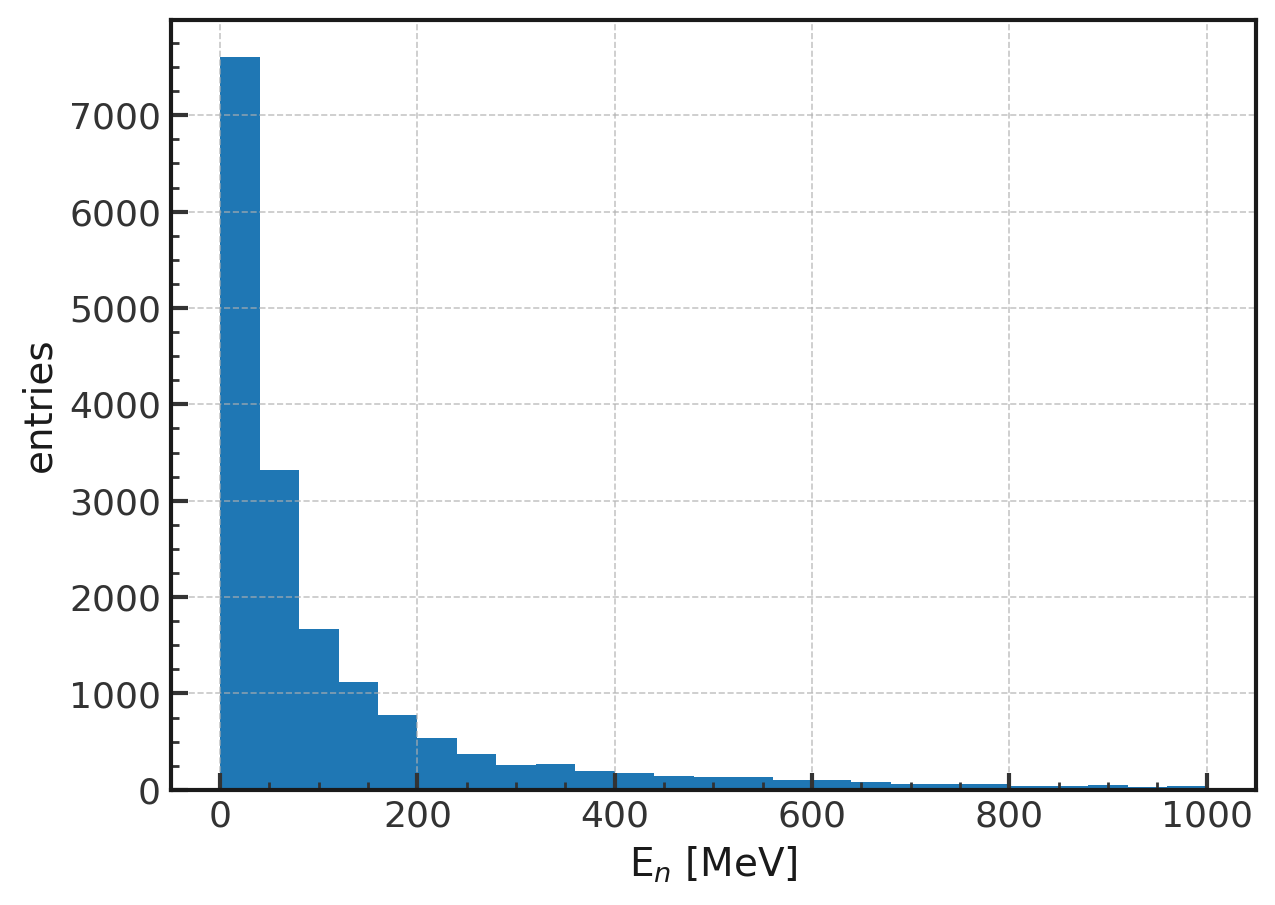

In [176]:
plt.hist(np.array(neutron_energy) - neutron_mass, histtype='stepfilled',bins=25, range=(0,1000))
plt.xlabel("E$_{n}$ [MeV]")
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_primary_energy.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_primary_energy.pdf",bbox_inches="tight")
plt.show()


Locator attempting to generate 1273 ticks ([-14.5, ..., 303.5]), which exceeds Locator.MAXTICKS (1000).


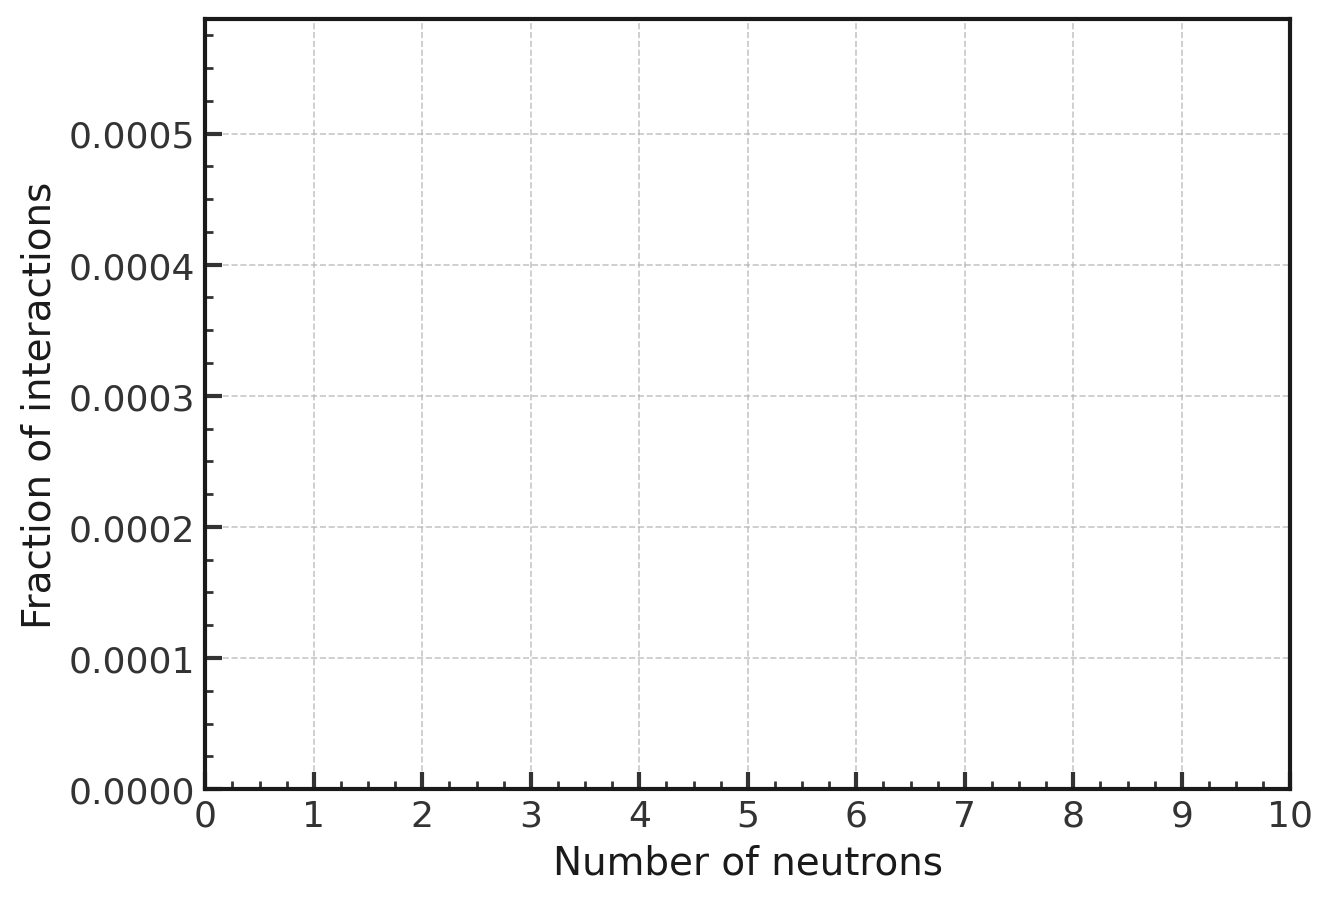

In [177]:
binning = np.linspace(0,np.max(n_neutrons),np.max(n_neutrons)+1)
(counts_neutrons,bins_final) = np.histogram(n_neutrons,bins=binning)
plt.hist(bins_final[:-1], bins = bins_final,weights=counts_neutrons/len(Ar_id), histtype='stepfilled')
plt.xticks(binning)
plt.xlabel("Number of neutrons")
plt.ylabel("Fraction of interactions")
plt.xlim(0,10)
plt.savefig(plot_dir + "number_of_neutrons_produced.png",bbox_inches="tight")
plt.savefig(plot_dir + "number_of_neutrons_produced.pdf",bbox_inches="tight")
plt.show()

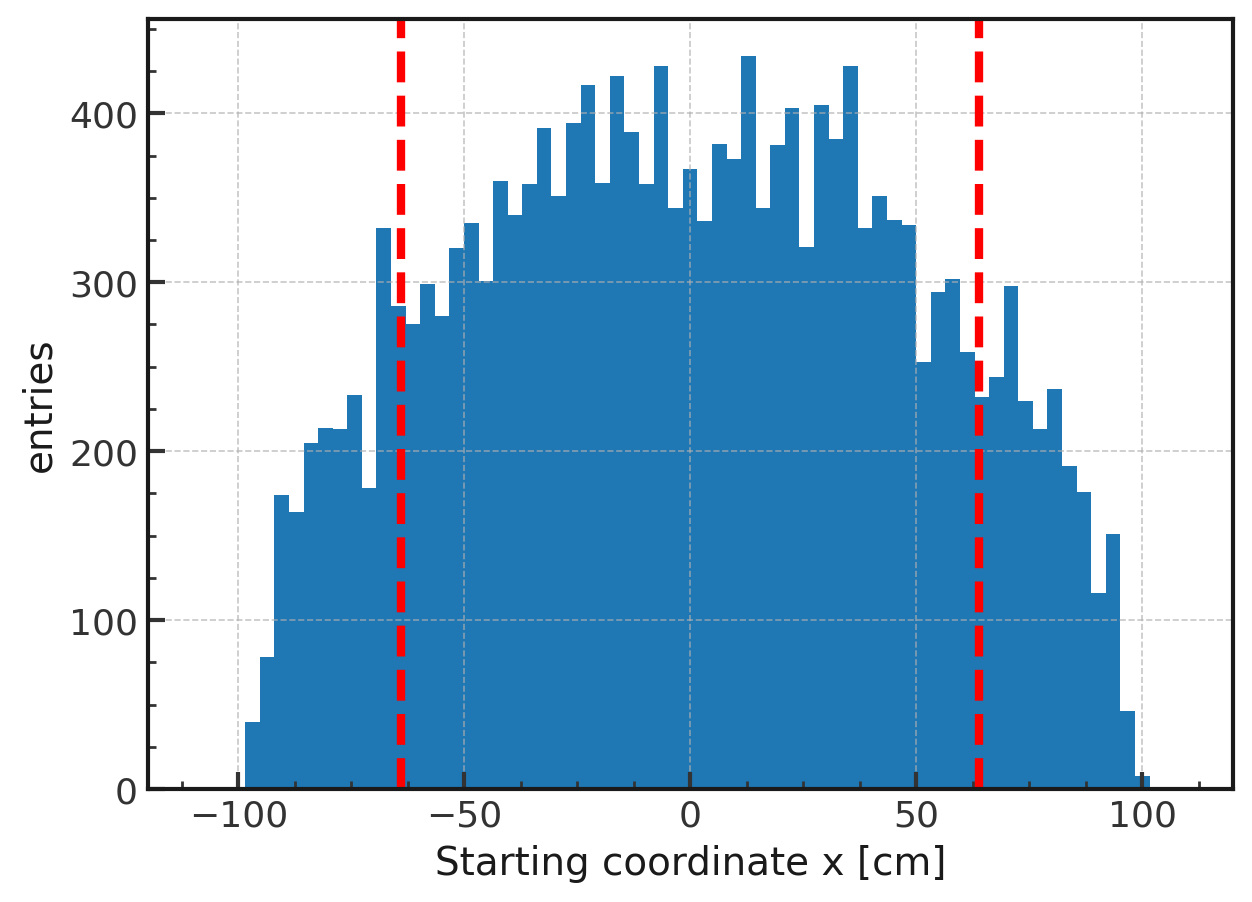

In [178]:
plt.hist(neutron_start_x, histtype='stepfilled',bins=80)
plt.xlabel("Starting coordinate x [cm]")
plt.ylabel("entries")
plt.axvline(anode_xs[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_xs[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-120,120)
plt.savefig(plot_dir + "neutron_start_x.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_start_x.pdf",bbox_inches="tight")
plt.show()


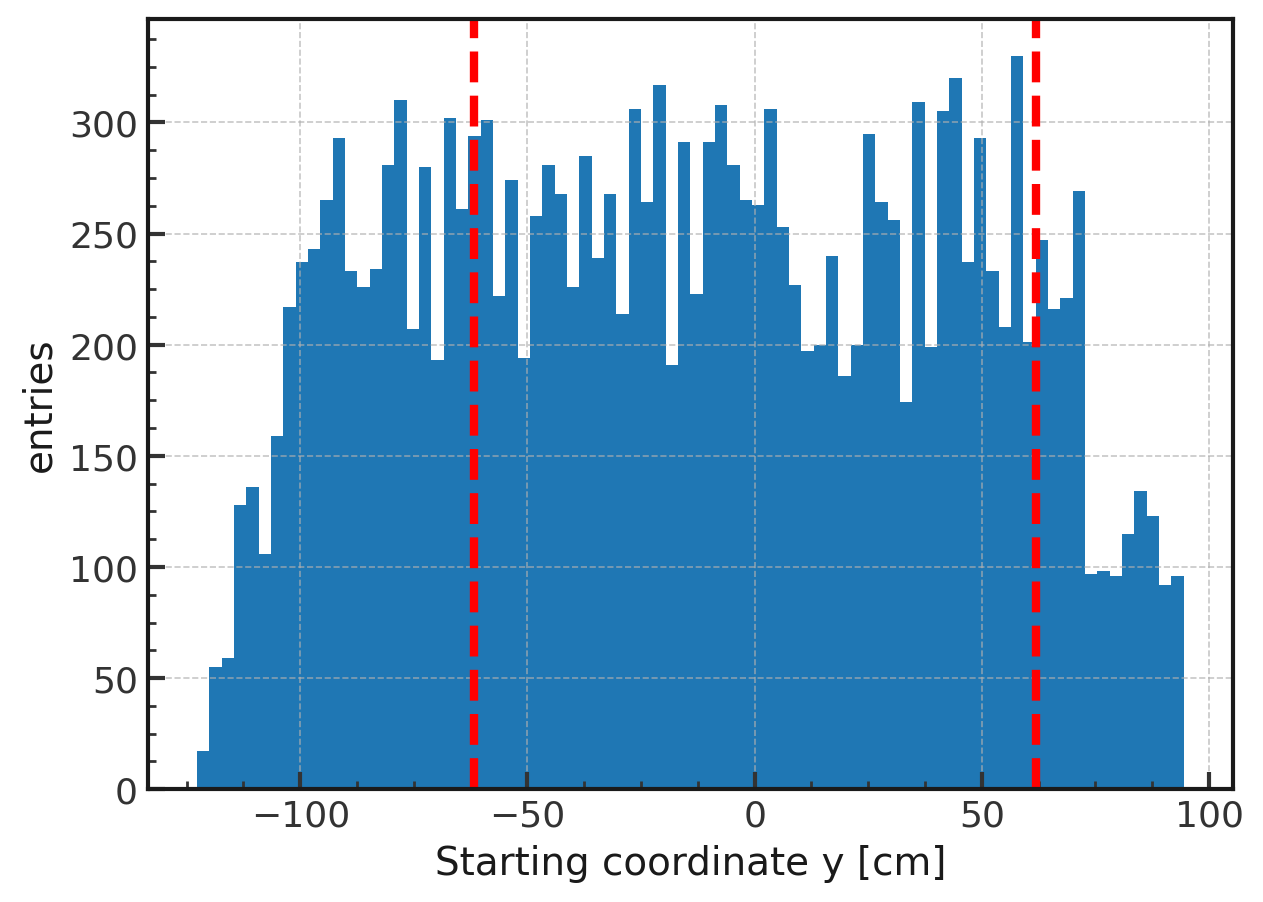

In [179]:
plt.hist(neutron_start_y, histtype='stepfilled',bins=80)
plt.xlabel("Starting coordinate y [cm]")
plt.ylabel("entries")
plt.axvline(anode_ys[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_ys[-1],0,1,ls="--",lw=3.,color='red')
plt.savefig(plot_dir + "neutron_start_y.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_start_y.pdf",bbox_inches="tight")
plt.show()

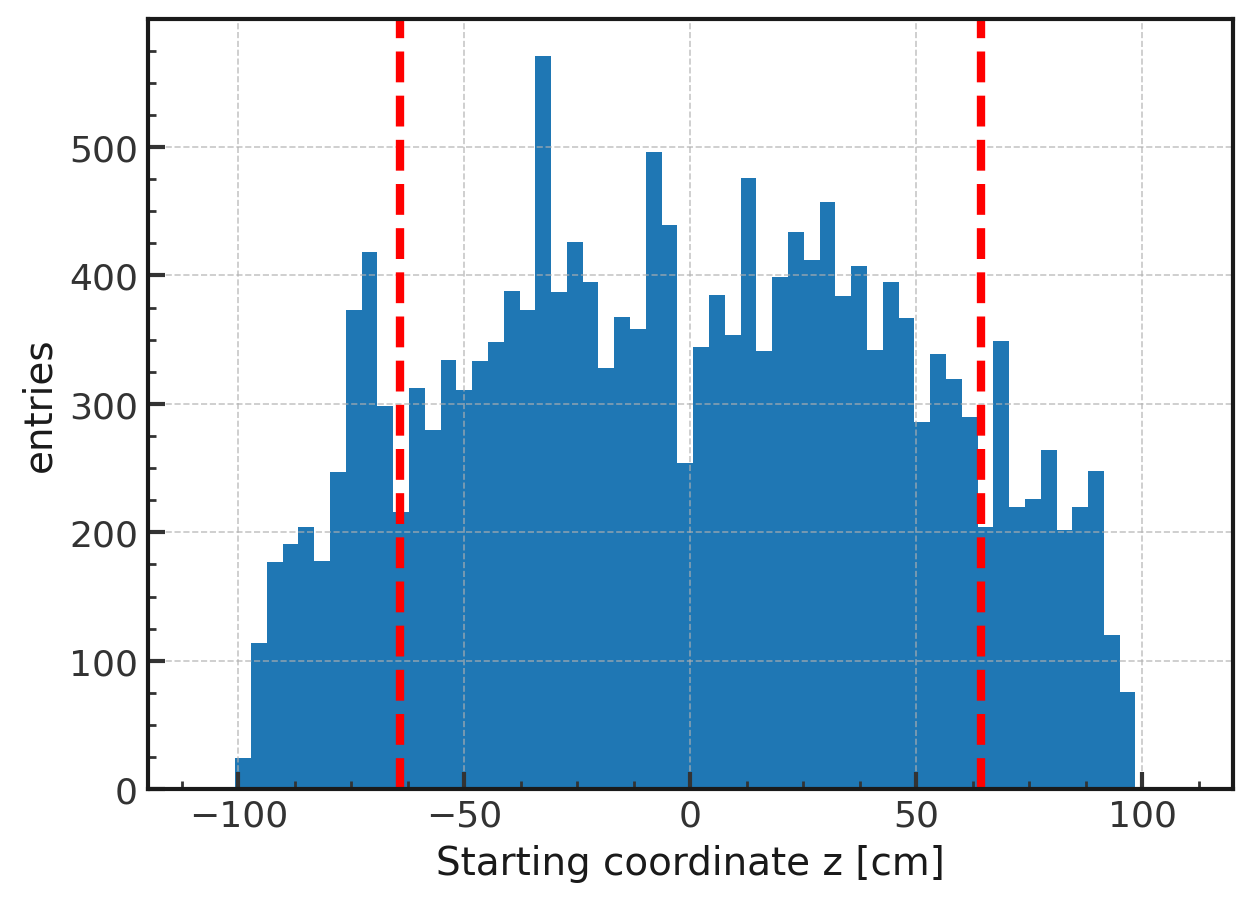

In [180]:
plt.hist(neutron_start_z, histtype='stepfilled',bins=80)
plt.xlabel("Starting coordinate z [cm]")
plt.ylabel("entries")
plt.axvline(anode_zs[0],0,1,ls="--",lw=3.,color='red')
plt.axvline(anode_zs[-1],0,1,ls="--",lw=3.,color='red')
plt.xlim(-120,120)
plt.savefig(plot_dir + "neutron_start_z.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_start_z.pdf",bbox_inches="tight")
plt.show()

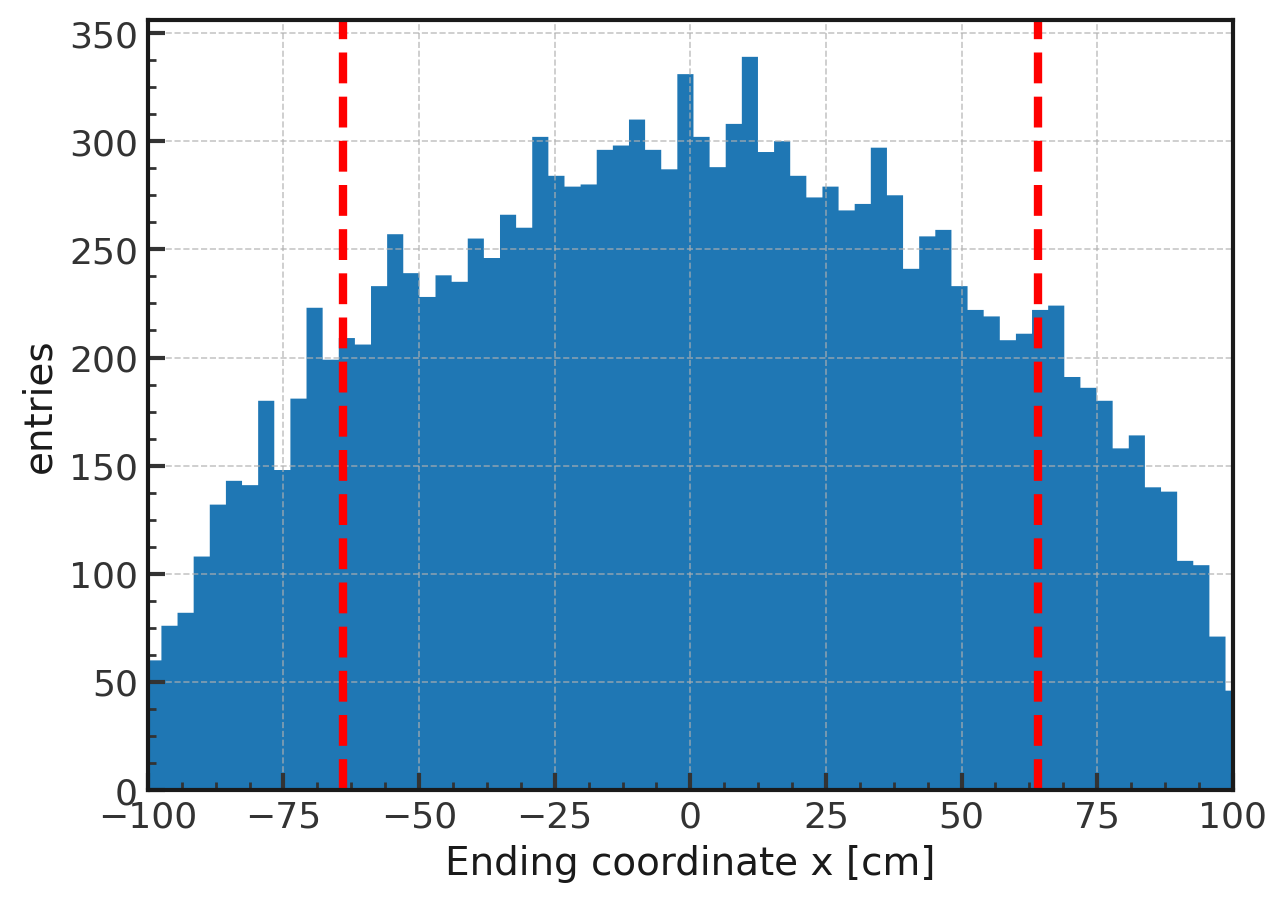

In [181]:
plt.hist(neutron_end_x, histtype='stepfilled',bins=500)
plt.axvline(64,0,1,ls="--",lw=3.,color='red')
plt.axvline(-64,0,1,ls="--",lw=3.,color='red')
plt.xlim(-100,100)
plt.xlabel("Ending coordinate x [cm]")
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_end_x.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_end_x.pdf",bbox_inches="tight")
plt.show()

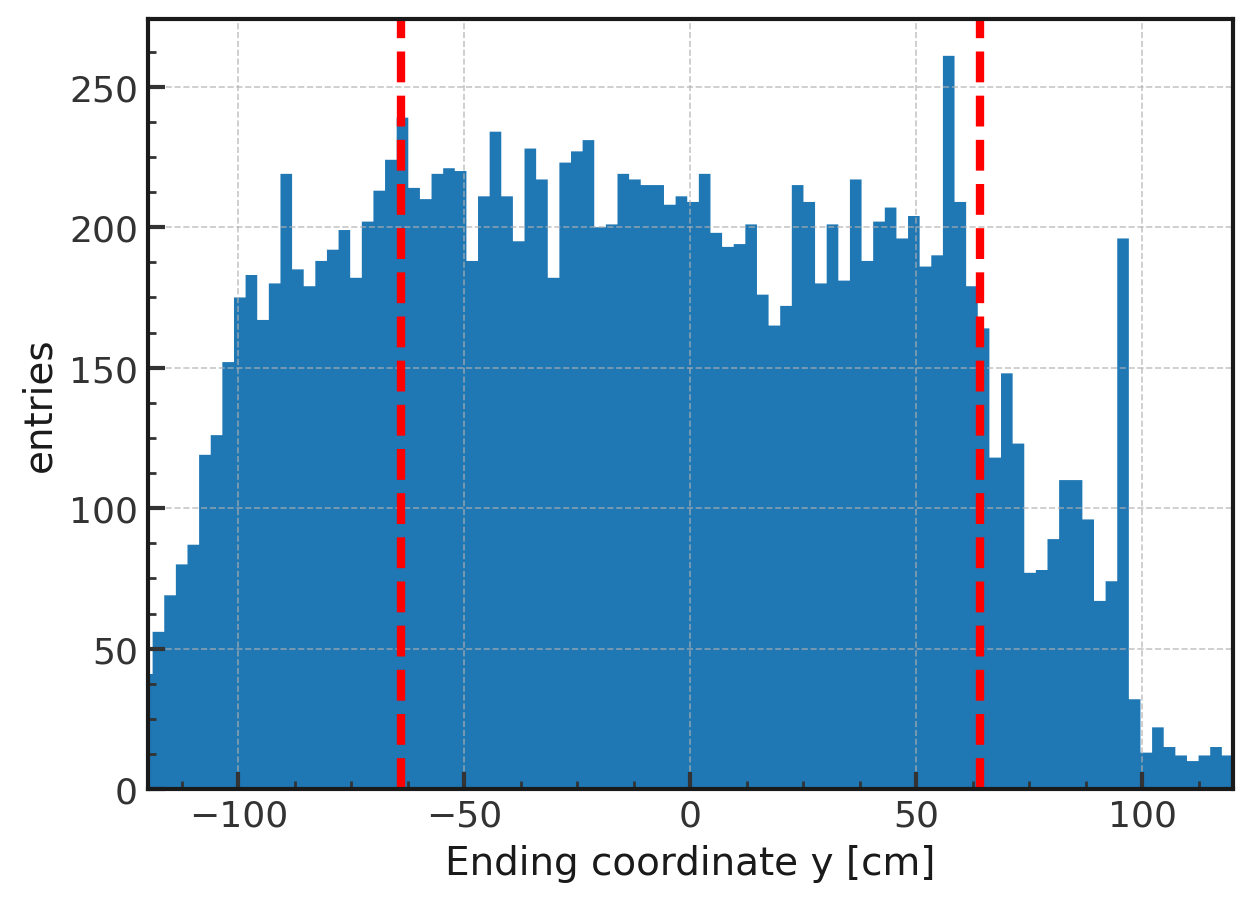

In [182]:
plt.hist(neutron_end_y, histtype='stepfilled',bins=500)
plt.axvline(-64,0,1,ls="--",lw=3.,color='red')
plt.axvline(64,0,1,ls="--",lw=3.,color='red')
plt.xlim(-120,120)
plt.xlabel("Ending coordinate y [cm]")
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_end_y.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_end_y.pdf",bbox_inches="tight")
plt.show()

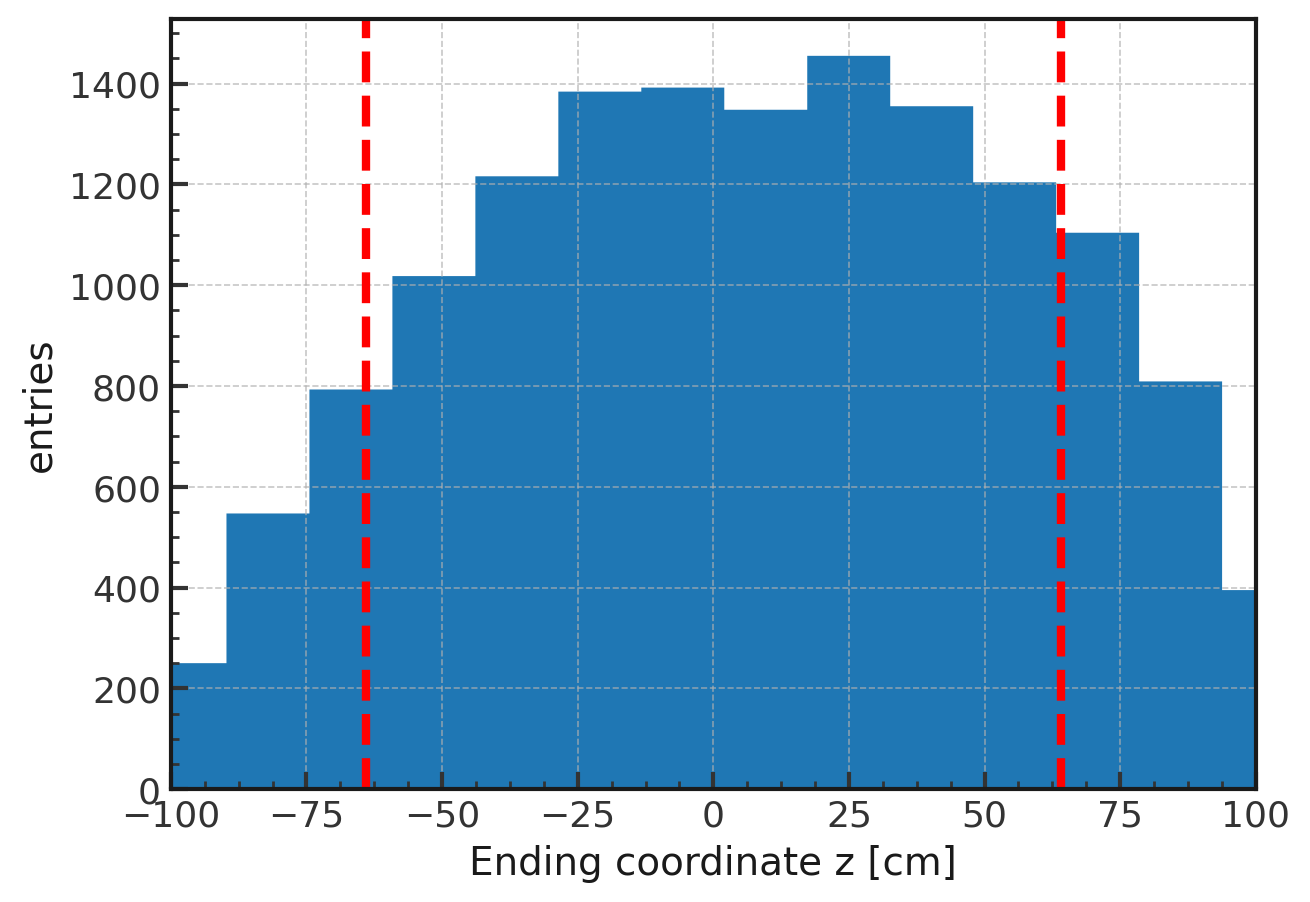

In [183]:
plt.hist(neutron_end_z, histtype='stepfilled',bins=500)
plt.axvline(64,0,1,ls="--",lw=3.,color='red')
plt.axvline(-64,0,1,ls="--",lw=3.,color='red')
plt.xlim(-100,100)
plt.xlabel("Ending coordinate z [cm]")
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_end_z.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_end_z.pdf",bbox_inches="tight")
plt.show()

788.1392


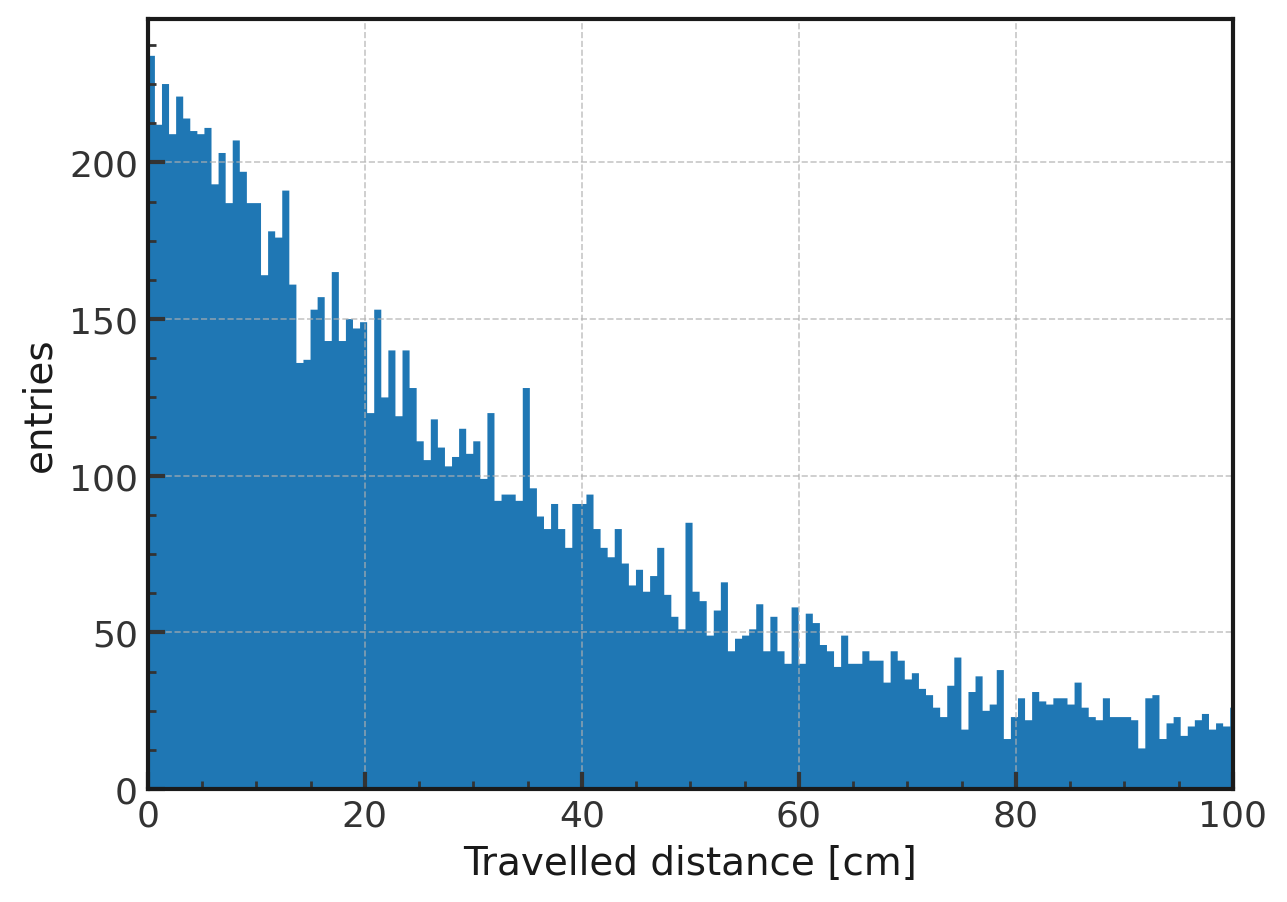

In [184]:
print(np.max(neutron_end_x))

delta_x = (np.array(neutron_start_x) - np.array(neutron_end_x))**2
delta_y = (np.array(neutron_start_y) - np.array(neutron_end_y))**2
delta_z = (np.array(neutron_start_z) - np.array(neutron_end_z))**2

neutron_travel_distance = np.sqrt(delta_x + delta_y + delta_z)



plt.hist(neutron_travel_distance, histtype='stepfilled',bins=10000)
plt.xlabel("Travelled distance [cm]")
plt.xlim(0,100)
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_distance_travelled.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_distance_travelled.pdf",bbox_inches="tight")
plt.show()

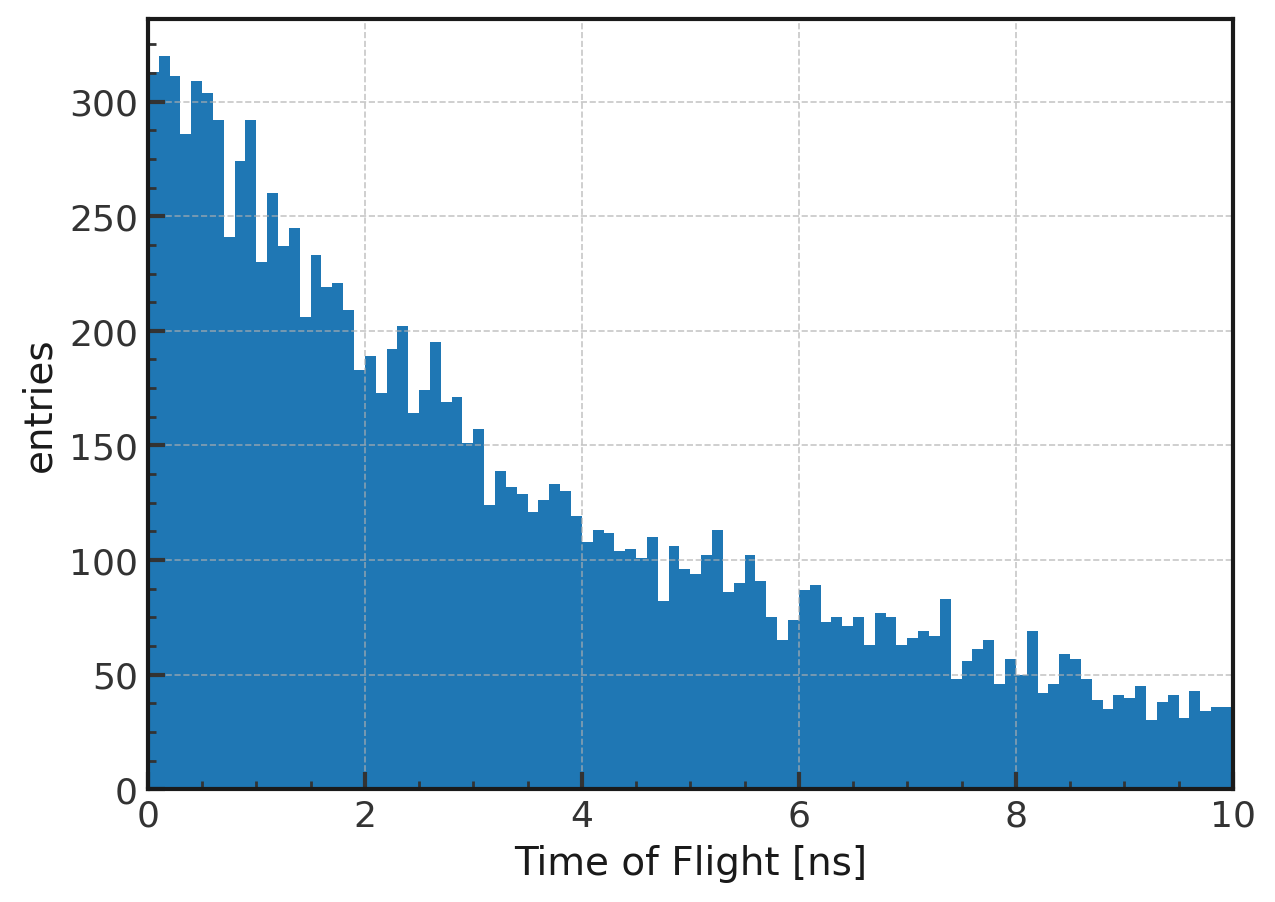

In [185]:
neutron_tof = (np.array(neutron_end_t) - np.array(neutron_start_t))*1e3
plt.hist(neutron_tof, histtype='stepfilled',bins=100,range=(0,10))
plt.xlabel("Time of Flight [ns]")
plt.xlim(0,10)
plt.ylabel("entries")
plt.savefig(plot_dir + "neutron_tof.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_tof.pdf",bbox_inches="tight")
plt.show()

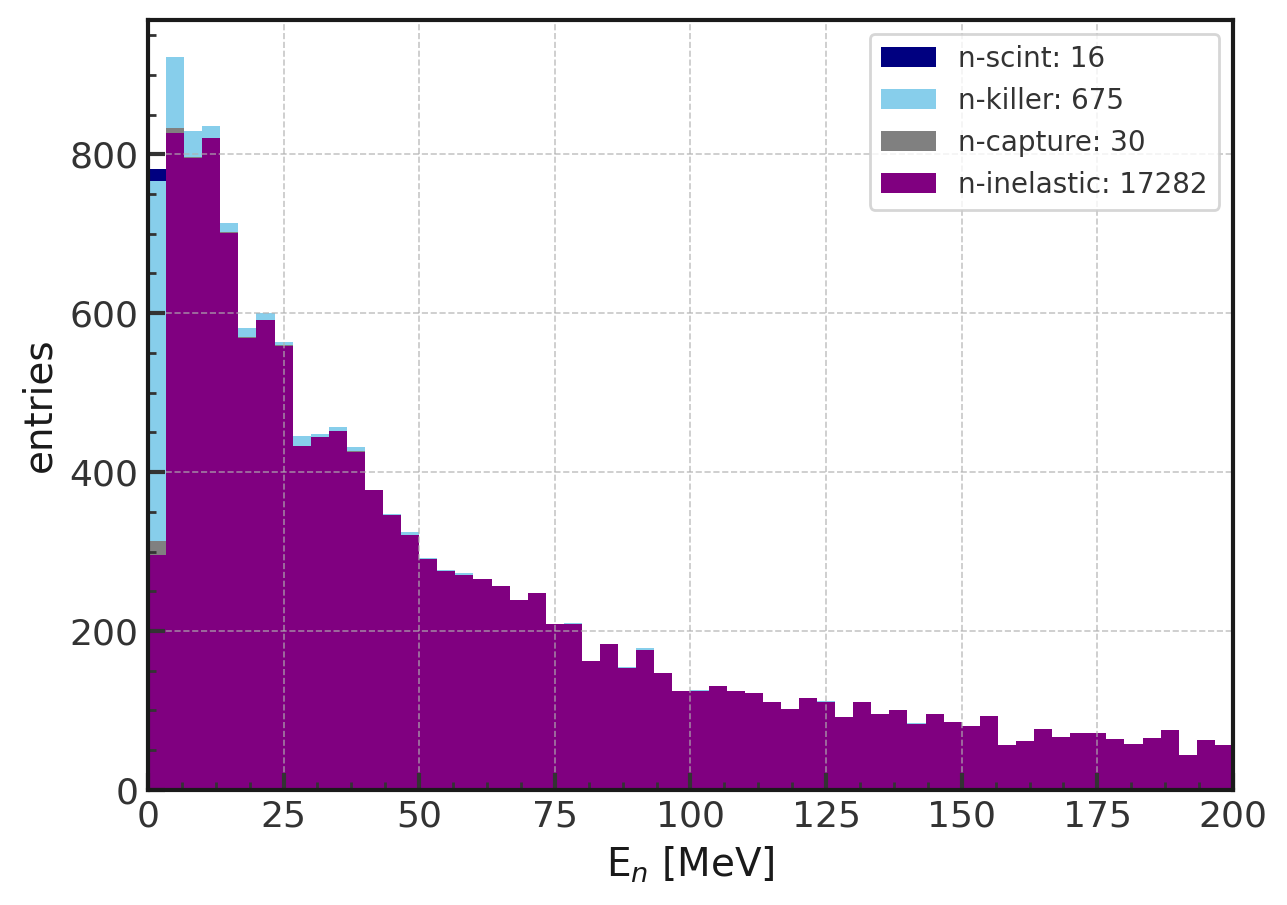

In [186]:
E_neutrons = [np.array(n_inelastic_E) - neutron_mass, np.array(n_capture_E)-neutron_mass, np.array(n_killer_E) - neutron_mass, np.array(n_em_E) - neutron_mass]
label = [f"n-inelastic: {len(n_inelastic_E)}", f"n-capture: {len(n_capture_E)}", f"n-killer: {len(n_killer_E)}", f"n-scint: {len(n_em_E)}"]
colors_stack = ['purple', 'gray','skyblue', 'navy']
plt.hist(E_neutrons, histtype='stepfilled', stacked=True, label=label, bins=60, range=(0,200),color=colors_stack)
plt.xlabel("E$_{n}$ [MeV]")
plt.ylabel("entries")
plt.xlim(0.,200.)
plt.legend()
plt.savefig(plot_dir + "neutron_energy_dist.png",bbox_inches="tight")
plt.savefig(plot_dir + "neutron_energy_dist.pdf",bbox_inches="tight")
plt.show()

In [187]:
print(MCStack[(MCStack['part_status']== 1) & (MCStack['vertex_id']==id) & (MCStack['part_pdg']==neutron_pdg)]['part_pdg'])

[]
